# Hatchet Benchmark + Task Status

Simple notebook to benchmark Hatchet tasks and track run statuses over time.

## Before running
- Start the relevant worker(s) in another terminal.
- Ensure `HATCHET_CLIENT_TOKEN` is set.
- Configure `TASK_INPUTS` in the next cell.


In [ ]:
import asyncio
import os
from datetime import datetime, timezone
from typing import Any

import pandas as pd
from dotenv import load_dotenv
from hatchet_sdk import Hatchet

from hatchet_playground.run_external import ExternalTaskRunner, TERMINAL_STATUSES

load_dotenv()
assert os.getenv("HATCHET_CLIENT_TOKEN"), "HATCHET_CLIENT_TOKEN is required"

hatchet = Hatchet()

# Map task name -> base input payload.
# For tasks with no input, use {}.
TASK_INPUTS: dict[str, dict[str, Any]] = {
    "externally-triggered-task": {"user_id": 1000},
    "sync-sleep-task": {},
}

RUNS_PER_TASK = 20
BENCHMARK_KEY_PREFIX = "task-status-benchmark-v1"
POLL_INTERVAL_SECONDS = 1.0


In [ ]:
def payload_for(task_name: str, run_index: int) -> dict[str, Any]:
    payload = dict(TASK_INPUTS.get(task_name, {}))
    if isinstance(payload.get("user_id"), int):
        payload["user_id"] = payload["user_id"] + run_index
    return payload


async def trigger_task_runs(task_name: str, runs_per_task: int) -> pd.DataFrame:
    payloads = [payload_for(task_name, i) for i in range(runs_per_task)]
    runner = ExternalTaskRunner(
        task_name=task_name,
        input_payload={},
        hatchet=hatchet,
    )
    keys = [f"{BENCHMARK_KEY_PREFIX}:{task_name}:{i}" for i in range(runs_per_task)]
    run_refs = await runner.trigger_many_no_wait(payloads, keys=keys)
    triggered_at = datetime.now(timezone.utc)

    rows = [
        {
            "task_name": task_name,
            "run_index": index,
            "workflow_run_id": run_ref.workflow_run_id,
            "triggered_at": triggered_at,
        }
        for index, run_ref in enumerate(run_refs)
    ]
    return pd.DataFrame(rows)


async def poll_statuses(run_df: pd.DataFrame) -> pd.DataFrame:
    run_ids = run_df["workflow_run_id"].tolist()
    run_to_task = dict(zip(run_df["workflow_run_id"], run_df["task_name"], strict=True))

    snapshots: list[dict[str, Any]] = []
    terminal_runs: set[str] = set()

    while len(terminal_runs) < len(run_ids):
        now = datetime.now(timezone.utc)
        statuses = await asyncio.gather(
            *(hatchet.runs.aio_get_status(run_id) for run_id in run_ids)
        )

        for run_id, status in zip(run_ids, statuses, strict=True):
            snapshots.append(
                {
                    "timestamp": now,
                    "workflow_run_id": run_id,
                    "task_name": run_to_task[run_id],
                    "status": status.value,
                }
            )
            if status in TERMINAL_STATUSES:
                terminal_runs.add(run_id)

        print(
            f"[{now.isoformat(timespec='seconds')}] terminal={len(terminal_runs)}/{len(run_ids)}"
        )

        if len(terminal_runs) < len(run_ids):
            await asyncio.sleep(POLL_INTERVAL_SECONDS)

    return pd.DataFrame(snapshots)


In [3]:
async def run_benchmark() -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    tasks = list(TASK_INPUTS)
    if not tasks:
        raise ValueError("TASK_INPUTS is empty. Add at least one task to run.")

    triggered_parts = [
        await trigger_task_runs(task_name, RUNS_PER_TASK) for task_name in tasks
    ]
    triggered_df = pd.concat(triggered_parts, ignore_index=True)

    snapshots_df = await poll_statuses(triggered_df)

    latest_df = (
        snapshots_df.sort_values("timestamp")
        .groupby("workflow_run_id", as_index=False)
        .tail(1)
        .rename(columns={"timestamp": "last_seen_at", "status": "final_status"})
    )[["workflow_run_id", "last_seen_at", "final_status"]]

    merged_df = triggered_df.merge(latest_df, on="workflow_run_id", how="left")
    merged_df["duration_seconds"] = (
        merged_df["last_seen_at"] - merged_df["triggered_at"]
    ).dt.total_seconds()

    return triggered_df, snapshots_df, merged_df


triggered_df, snapshots_df, merged_df = await run_benchmark()

print("Final status counts:")
display(
    merged_df.groupby(["task_name", "final_status"], as_index=False)
    .size()
    .rename(columns={"size": "count"})
)

print("Duration summary (seconds):")
display(merged_df.groupby("task_name", as_index=False)["duration_seconds"].describe())


[2026-02-15T10:39:59+00:00] terminal=6/40
[2026-02-15T10:40:02+00:00] terminal=20/40
[2026-02-15T10:40:03+00:00] terminal=20/40
[2026-02-15T10:40:05+00:00] terminal=20/40
[2026-02-15T10:40:06+00:00] terminal=20/40
[2026-02-15T10:40:07+00:00] terminal=20/40
[2026-02-15T10:40:09+00:00] terminal=20/40
[2026-02-15T10:40:10+00:00] terminal=23/40
[2026-02-15T10:40:11+00:00] terminal=23/40
[2026-02-15T10:40:13+00:00] terminal=23/40
[2026-02-15T10:40:14+00:00] terminal=23/40
[2026-02-15T10:40:15+00:00] terminal=23/40
[2026-02-15T10:40:16+00:00] terminal=23/40
[2026-02-15T10:40:18+00:00] terminal=23/40
[2026-02-15T10:40:19+00:00] terminal=23/40
[2026-02-15T10:40:20+00:00] terminal=26/40
[2026-02-15T10:40:22+00:00] terminal=26/40
[2026-02-15T10:40:23+00:00] terminal=26/40
[2026-02-15T10:40:24+00:00] terminal=26/40
[2026-02-15T10:40:26+00:00] terminal=26/40
[2026-02-15T10:40:27+00:00] terminal=26/40
[2026-02-15T10:40:28+00:00] terminal=26/40
[2026-02-15T10:40:29+00:00] terminal=29/40
[2026-02-15T

,task_name,final_status,count
0,externally-triggered-task,COMPLETED,20
1,sync-sleep-task,COMPLETED,20


Duration summary (seconds):


,task_name,count,mean,std,min,25%,50%,75%,max
0,externally-triggered-task,20.0,71.215780,0.000000e+00,71.215780,71.215780,71.215780,71.215780,71.215780
1,sync-sleep-task,20.0,71.207329,1.458003e-14,71.207329,71.207329,71.207329,71.207329,71.207329


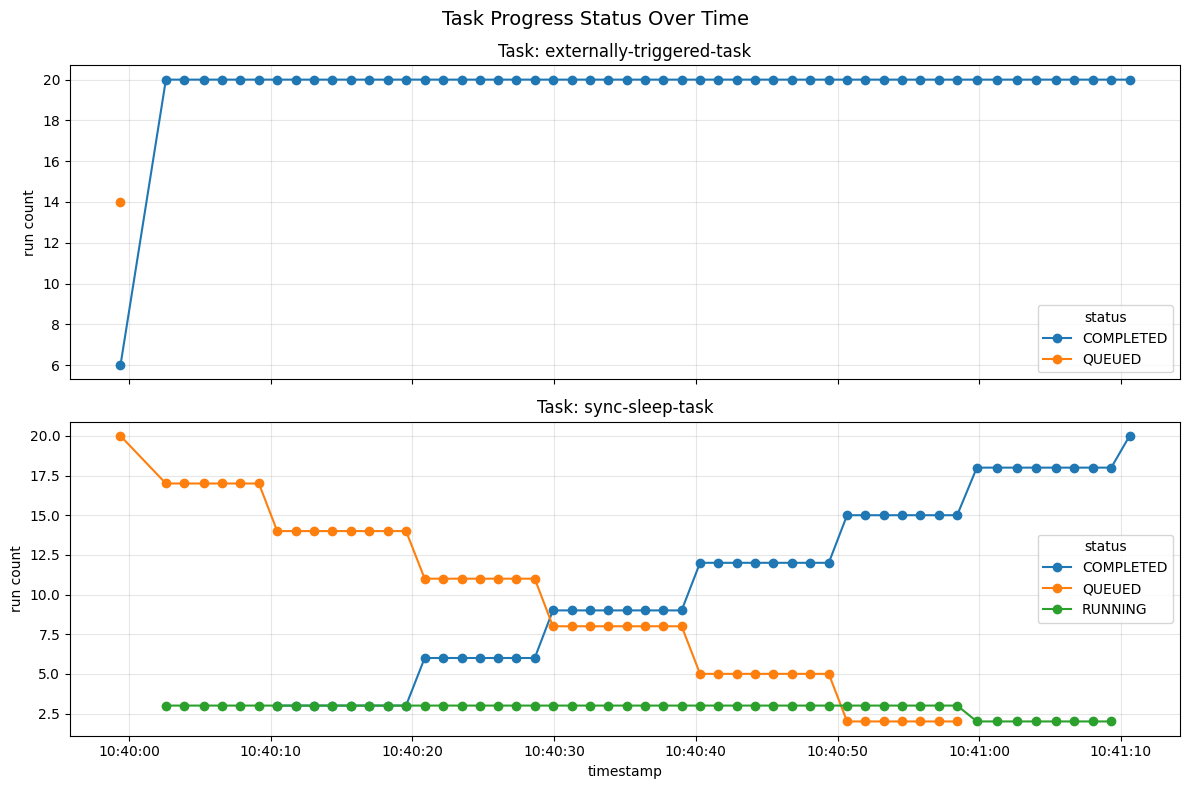

Latest status snapshot:


,timestamp,task_name,status,count
179,2026-02-15 10:41:02.637998+00:00,externally-triggered-task,COMPLETED,20
180,2026-02-15 10:41:02.637998+00:00,sync-sleep-task,COMPLETED,18
181,2026-02-15 10:41:02.637998+00:00,sync-sleep-task,RUNNING,2
182,2026-02-15 10:41:04.021721+00:00,externally-triggered-task,COMPLETED,20
183,2026-02-15 10:41:04.021721+00:00,sync-sleep-task,COMPLETED,18
184,2026-02-15 10:41:04.021721+00:00,sync-sleep-task,RUNNING,2
185,2026-02-15 10:41:05.421691+00:00,externally-triggered-task,COMPLETED,20
186,2026-02-15 10:41:05.421691+00:00,sync-sleep-task,COMPLETED,18
187,2026-02-15 10:41:05.421691+00:00,sync-sleep-task,RUNNING,2
188,2026-02-15 10:41:06.719917+00:00,externally-triggered-task,COMPLETED,20


In [4]:
import matplotlib.pyplot as plt

status_counts_df = (
    snapshots_df.groupby(["timestamp", "task_name", "status"], as_index=False)
    .size()
    .rename(columns={"size": "count"})
)

task_names = sorted(status_counts_df["task_name"].unique())
fig, axes = plt.subplots(
    len(task_names), 1, figsize=(12, 4 * max(1, len(task_names))), sharex=True
)
if len(task_names) == 1:
    axes = [axes]

for ax, task_name in zip(axes, task_names, strict=True):
    task_df = status_counts_df[status_counts_df["task_name"] == task_name]
    for status in sorted(task_df["status"].unique()):
        line_df = task_df[task_df["status"] == status].sort_values("timestamp")
        ax.plot(line_df["timestamp"], line_df["count"], marker="o", label=status)
    ax.set_title(f"Task: {task_name}")
    ax.set_ylabel("run count")
    ax.grid(alpha=0.3)
    ax.legend(title="status")

axes[-1].set_xlabel("timestamp")
fig.suptitle("Task Progress Status Over Time", fontsize=14)
plt.tight_layout()
plt.show()

print("Latest status snapshot:")
display(status_counts_df.sort_values(["timestamp", "task_name", "status"]).tail(20))
